# Classification of Oxford Pets

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Для начала загружаем датасет:

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

In [3]:
import torch

In [4]:
import torchvision

In [6]:
#shutil.rmtree("dest_dir")
#shutil.rmtree("images")

## Загрузка датасета + preprocessing

In [7]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/oxpets_images.tar.gz
!tar xfz oxpets_images.tar.gz
!rm oxpets_images.tar.gz

--2022-05-28 21:13:58--  https://mslearntensorflowlp.blob.core.windows.net/data/oxpets_images.tar.gz
Resolving mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)... 20.150.90.68
Connecting to mslearntensorflowlp.blob.core.windows.net (mslearntensorflowlp.blob.core.windows.net)|20.150.90.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘oxpets_images.tar.gz’

oxpets_images.tar.g 100%[===================>] 755.23M  59.1MB/s    in 13s     

2022-05-28 21:14:11 (58.9 MB/s) - ‘oxpets_images.tar.gz’ saved [791918971/791918971]



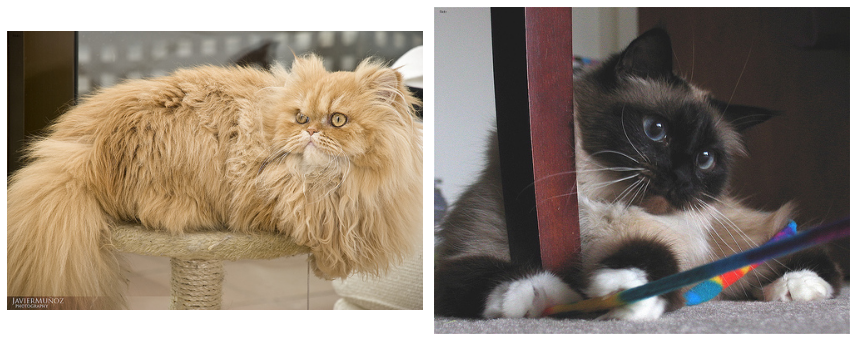

In [8]:
from PIL import Image

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()


display_images([Image.open(os.path.join('images',x)) 
                for x in os.listdir(os.path.join('images'))[:2]])

три картинки оказались с расширением mat - удалим их

In [9]:
os.remove('images/Abyssinian_100.mat')
os.remove('images/Abyssinian_101.mat')
os.remove('images/Abyssinian_102.mat')

In [10]:
len(os.listdir('images'))

7390

 Придется удалить часть данных тк ОЗУ не справляется.

In [11]:
for f in os.listdir('images'):
    if np.random.rand(1) < 0.70:
        os.remove('images' + '/'+ f)

In [12]:
len(os.listdir('images'))

2151

In [13]:
os.mkdir("dest_dir")

In [14]:
for f in os.listdir('images'):
    if np.random.rand(1) < 0.2:
        shutil.move('images' + '/'+ f, "dest_dir")

Выделим классы

In [15]:
classes = []

first = '_'.join(os.listdir('dest_dir')[0].split('_')[:-1])
classes.append(first)

for ims in os.listdir('dest_dir'):
  if '_'.join(ims.split('_')[:-1]) not in classes:
    classes.append('_'.join(ims.split('_')[:-1]))

len(classes)


37

Создадим папки с классами

In [16]:
for cls in classes:
  os.mkdir('images' + '/' + cls)
  os.mkdir('dest_dir' + '/' + cls)

In [17]:
for ims in os.listdir('dest_dir'):
  if 'jpg' in ims:
    shutil.move('dest_dir' + '/'+ ims, "dest_dir"+ '/' + '_'.join(ims.split('_')[:-1]))

In [18]:
for ims in os.listdir('images'):
  if 'jpg' in ims:
    shutil.move('images' + '/'+ ims, 'images'+ '/' + '_'.join(ims.split('_')[:-1]))

Проверим

In [19]:
num_classes_train = len(os.listdir('images'))
num_classes_test = len(os.listdir('dest_dir'))
print(num_classes_train, num_classes_test)

37 37


In [20]:
sum = 0
for cls in os.listdir('images'):
    sum += len(os.listdir('images'+'/'+cls))
sum

1720

In [21]:
sum = 0
for cls in os.listdir('dest_dir'):
    sum += len(os.listdir('dest_dir'+'/'+cls))

batch_test = sum
sum

431

Теперь данные разделены на test - dest_dir и train - images.

In [22]:
train_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((128,128)),
            #torchvision.transforms.RandomHorizontalFlip(0.3),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

imagenet_data = torchvision.datasets.ImageFolder('dest_dir',  transform = train_transform)
data_loader_test = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=batch_test,
                                          shuffle=True)

batch_size=100
imagenet_data = torchvision.datasets.ImageFolder('images',  transform = train_transform)
data_loader_train = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=batch_size,
                                          shuffle=True)

## Модель + обучение

In [23]:
def train(net, dataloader, epochs, lr , los_func):
  acc_s = []
  loss_s = []

  optimizer = torch.optim.Adam(net.parameters(),lr=lr)

  los = 0.
  for epoch in range(epochs): 
    print("epoch", epoch)
    correct = 0.
    for X, y in dataloader: 
        #print(y)
        #net.zero_grad()  
        z = net(X)  
        loss = los_func(z, y) 
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        los += loss.item() * batch_size
        _, pred = torch.max(z, 1)
        correct += (pred == y).float().sum()
    #print(correct)
    los /= len(dataloader.dataset)
    acc = correct / len(dataloader.dataset)
    acc_s.append(acc)
    loss_s.append(los)
    print('{}. loss = {:.6f}. acc = {:.6f}'.format(epoch, los, acc))

  return acc_s, loss_s

In [24]:
def test(net, dataloader, los_func):
  los = 0.
  correct = 0.
  for x, y in dataloader:
    z = net(x)
    loss = los_func(z,y)
    los += loss.item() * batch_test
    pred = torch.max(z, 1)[1] 
    correct += (pred == y).float().sum()

  los /= len(dataloader.dataset)
  acc = correct / len(dataloader.dataset)
  print(f"Test : loss = {los}, acc = {acc}")
  return acc, los

In [25]:
def train_and_plot(net, dataloader, epochs, lr, los_func):
  acc, loss = train(net, dataloader, epochs, lr, los_func)
  plt.ylabel('accuracy/loss')
  plt.xlabel('epochs')
  plt.plot(range(epochs), acc, 'r')
  plt.plot(range(epochs), loss, 'g')
  plt.legend({'accuracy', 'loss'})
  plt.show()

In [26]:
def predict(net, x):
  z = net(x)
  pred = torch.max(z, 1)[1] 
  #print(pred.numpy())
  return pred.numpy()

In [27]:
from torchvision import models
from torchsummary import summary

Сеть VGG16

In [83]:
model = torchvision.models.vgg16(pretrained=True)

print(model.classifier)

model.classifier = torch.nn.Sequential(torch.nn.Linear(in_features=25088, out_features=4096, bias=True),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Dropout(p=0.5, inplace=False),
                                       torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Dropout(p=0.5, inplace=False),
                                       torch.nn.Linear(in_features=4096, out_features=37, bias=True))

#if you only want to keep the convolutional part of VGG16 fixed:
for x in model.features.parameters():
    x.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


epoch 0
0. loss = 2.177019. acc = 0.419672
epoch 1
1. loss = 0.781336. acc = 0.762842
epoch 2
2. loss = 0.530158. acc = 0.834426
epoch 3
3. loss = 0.285471. acc = 0.914754
epoch 4
4. loss = 0.208306. acc = 0.937705
epoch 5
5. loss = 0.166127. acc = 0.945902
epoch 6
6. loss = 0.103196. acc = 0.972131
epoch 7
7. loss = 0.076673. acc = 0.978142
epoch 8
8. loss = 0.053581. acc = 0.986339
epoch 9
9. loss = 0.053030. acc = 0.989071


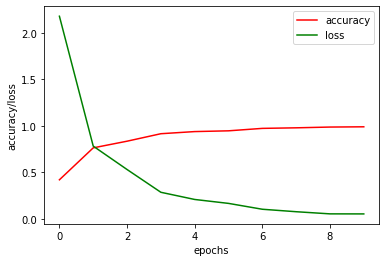

In [84]:
train_and_plot(model, data_loader_train, epochs = 10,lr = 0.0001, los_func = torch.nn.functional.cross_entropy) 

In [85]:
test(model, data_loader_test, los_func = torch.nn.functional.cross_entropy)

Test : loss = 0.8971796035766602, acc = 0.767699122428894


(tensor(0.7677), 0.8971796035766602)

Confusion matrix

452


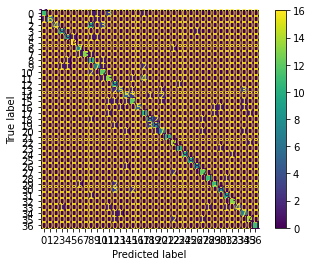

In [86]:
for x, y in data_loader_test: 
  print(len(x))
  cm = confusion_matrix(y, predict(model, x))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

Сеть ResNet

In [28]:
model2 = torchvision.models.resnet50(pretrained=True)

model2.fc = torch.nn.Sequential(torch.nn.Linear(in_features=2048, out_features=4096, bias=True), 
                                    torch.nn.ReLU(inplace=True),
                                    torch.nn.Dropout(p=0.5, inplace=False),
                                    torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
                                    torch.nn.ReLU(inplace=True),
                                    torch.nn.Dropout(p=0.5, inplace=False),
                                    torch.nn.Linear(4096, 37))

for param in model2.parameters():
    param.requires_grad = False

for param in model2.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch 0
0. loss = 3.521231. acc = 0.186628
epoch 1
1. loss = 2.561716. acc = 0.501744
epoch 2
2. loss = 1.679578. acc = 0.598256
epoch 3
3. loss = 1.239104. acc = 0.674419
epoch 4
4. loss = 1.048235. acc = 0.729651
epoch 5
5. loss = 0.923777. acc = 0.761047
epoch 6
6. loss = 0.752914. acc = 0.809884
epoch 7
7. loss = 0.700065. acc = 0.817442
epoch 8
8. loss = 0.642902. acc = 0.830233
epoch 9
9. loss = 0.601964. acc = 0.829070


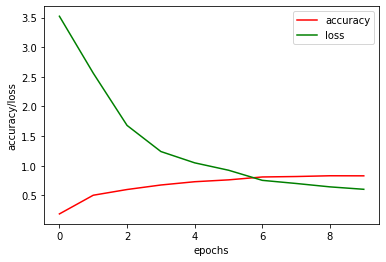

In [29]:
train_and_plot(model2, data_loader_train, epochs = 10,lr = 0.0001, los_func = torch.nn.functional.cross_entropy) 

In [30]:
test(model2, data_loader_test, los_func = torch.nn.functional.cross_entropy)

Test : loss = 0.9901108741760254, acc = 0.6937354803085327


(tensor(0.6937), 0.9901108741760254)

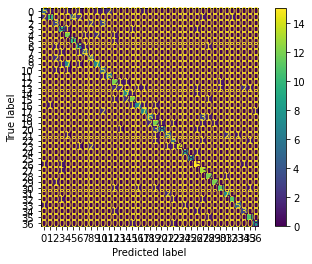

In [31]:
for x, y in data_loader_test:
  cm = confusion_matrix(y, predict(model2, x))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

Лучшую точность показала модель VGG16 - 77%, ResNet - 69%.

## Кошки VS Собаки

In [32]:
imagenet_data = torchvision.datasets.ImageFolder('dest_dir',  transform = train_transform)
imagenet_data.class_to_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [33]:
cat = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
dog = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

In [34]:
def test(net, dataloader, los_func):
  los = 0.
  correct = 0.
  for x, y in dataloader:
    z = net(x)
    loss = los_func(z,y)
    los += loss.item() * batch_test
    pred = torch.max(z, 1)[1] 
    true = torch.zeros(batch_test)
    for idx, i in enumerate(pred):
      if (i in cat and y[idx] in cat) or (i in dog and y[idx] in dog):
        true[idx] = 1
    correct += (true).float().sum()

  los /= len(dataloader.dataset)
  acc = correct / len(dataloader.dataset)
  print(f"Test : loss = {los}, acc = {acc}")
  return acc, los

In [35]:
test(model2, data_loader_test, los_func = torch.nn.functional.cross_entropy)

Test : loss = 0.9104756712913513, acc = 0.9512761235237122


(tensor(0.9513), 0.9104756712913513)

## Top-3

In [36]:
def test(net, dataloader, los_func):
  los = 0.
  correct = 0.
  for x, y in dataloader:
    z = net(x)
    loss = los_func(z,y)
    los += loss.item() * batch_test
    pred = torch.topk(z,3,1)[1] 
    true = torch.zeros(batch_test)
    for idx, i in enumerate(pred):
      if y[idx] in i:
        true[idx] = 1
    correct += (true).float().sum()

  los /= len(dataloader.dataset)
  acc = correct / len(dataloader.dataset)
  print(f"Test : loss = {los}, acc = {acc}")
  return acc, los

In [37]:
test(model2, data_loader_test, los_func = torch.nn.functional.cross_entropy)

Test : loss = 0.9432927370071411, acc = 0.9002320170402527


(tensor(0.9002), 0.9432927370071411)